In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

from metavision_core.event_io import RawReader

import lib

import rssr

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['svg.fonttype'] = 'none'

#import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Height: 720, Width: 1280
First event after transformation: (458, -262, 0, 1)
Data type of events['y']: int32


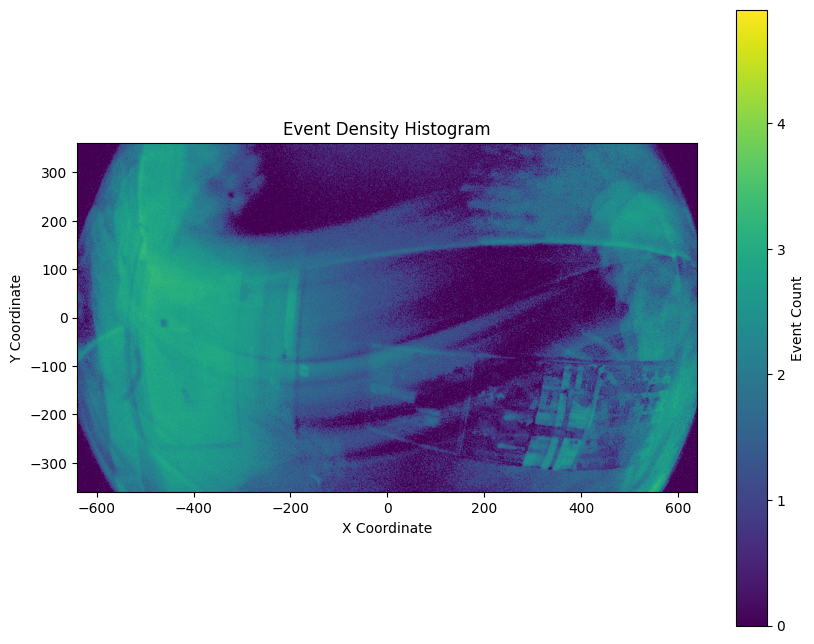

In [3]:
from metavision_sdk_base import EventCD
from metavision_sdk_core import BaseFrameGenerationAlgorithm
#from metavision_ml.preprocessing.viz import viz_histo
from metavision_ml.preprocessing.event_to_tensor import histo

import numpy as np

calib_file = 'rssr_dataset/kalibrace_end/recording_2025-01-10_13-31-14.raw'

raw = RawReader(calib_file)

h, w = raw.get_size()
print(f"Height: {h}, Width: {w}")
start_ts = 0.5 * 1e6
dt = 7.5 * 1e6

height, width = raw.get_size()
raw.seek_time(start_ts)

delta_t = dt
events = raw.load_delta_t(delta_t)
events['t'] -= int(start_ts)

# Convert x and y to int32 immediately after loading to prevent uint16 overflow
original_dtype = events.dtype

new_dtype = []
for field in original_dtype.names:
    if field == 'x' or field == 'y':
        new_dtype.append((field, np.int32))
    else:
        new_dtype.append((field, original_dtype[field]))
events = events.astype(new_dtype)

events_err = events[(events['x'] >= w) | (events['y'] >= h)]
if len(events_err) > 0:
    print(f"Warning: Found {len(events_err)} events outside frame!")
    print(events_err)

events['x'] -= w // 2
events['y'] -= h // 2

print(f"First event after transformation: {events[0]}")
print(f"Data type of events['y']: {events['y'].dtype}")
    
hist, x_edges, y_edges = np.histogram2d(
    events['x'],  # x-coordinates
    events['y'],  # y-coordinates
    bins=[w, h],  # Number of bins (width and height of the sensor)
    range=[[-w//2, w//2], [-h//2, h//2]]  # Range of x and y coordinates
)

# Plot the histogram
plt.figure(figsize=(10, 8))
plt.imshow(np.log1p(hist.T), origin='lower', cmap='viridis', extent=[-w//2, w//2, -h//2, h//2])
plt.colorbar(label='Event Count')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Event Density Histogram')
plt.show()


Optimized Major Axis (a): 652.1955712273414
Optimized Minor Axis (b): 650.5045931111749
Fixed Rotation Angle (theta): 0.0 degrees


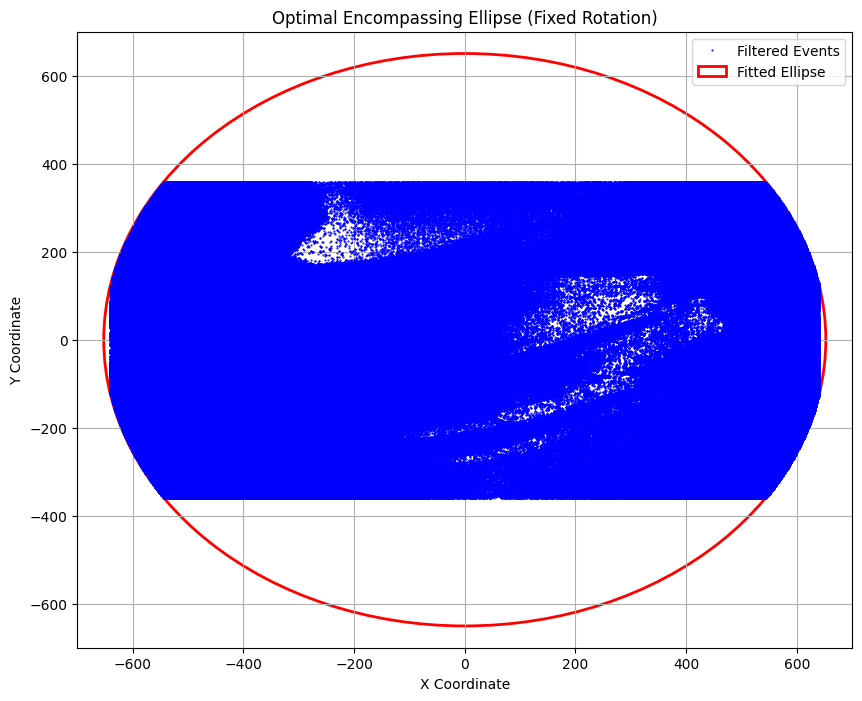

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Ellipse

# Load events data (assuming `events` is already loaded)
x = events['x']
y = events['y']
points = np.column_stack((x, y))

# Filter points to remove outliers (optional)
distances = np.sqrt(x**2 + y**2)
percentile_cutoff = np.percentile(distances, 99)
filtered_points = points[distances <= percentile_cutoff]
x_filt, y_filt = filtered_points[:, 0], filtered_points[:, 1]

# Define the cost function (only for a and b)
def ellipse_cost(params, points):
    a, b = params
    x, y = points[:, 0], points[:, 1]
    
    # Check if points lie inside the ellipse (no rotation, theta = 0)
    inside = (x**2 / a**2) + (y**2 / b**2) <= 1
    
    # Cost: sum of squared distances for points outside the ellipse
    cost = np.sum((x[~inside]**2 / a**2) + (y[~inside]**2 / b**2) - 1)
    return cost

# Initial guess for ellipse parameters (a and b only)
initial_guess = [650, 650]  # [a, b]

# Optimize the ellipse parameters (a and b only)
result = minimize(ellipse_cost, initial_guess, args=(filtered_points,), method='L-BFGS-B')
a_opt, b_opt = result.x

# Fixed rotation angle (theta = 0)
theta_opt = 0

# Print the optimized parameters
print(f"Optimized Major Axis (a): {a_opt}")
print(f"Optimized Minor Axis (b): {b_opt}")
print(f"Fixed Rotation Angle (theta): {np.degrees(theta_opt)} degrees")

# Plot the data points and the fitted ellipse
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_filt, y_filt, 'b.', markersize=1, label='Filtered Events')

ellipse = Ellipse(
    xy=(0, 0),
    width=2 * a_opt,
    height=2 * b_opt,
    angle=np.degrees(theta_opt),
    edgecolor='red',
    facecolor='none',
    linewidth=2,
    label='Fitted Ellipse'
)
ax.add_patch(ellipse)

# Axis labels and limits
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Optimal Encompassing Ellipse (Fixed Rotation)')
plt.legend(loc='upper right')
plt.xlim(-700, 700)
plt.ylim(-700, 700)
plt.grid(True)
plt.show()

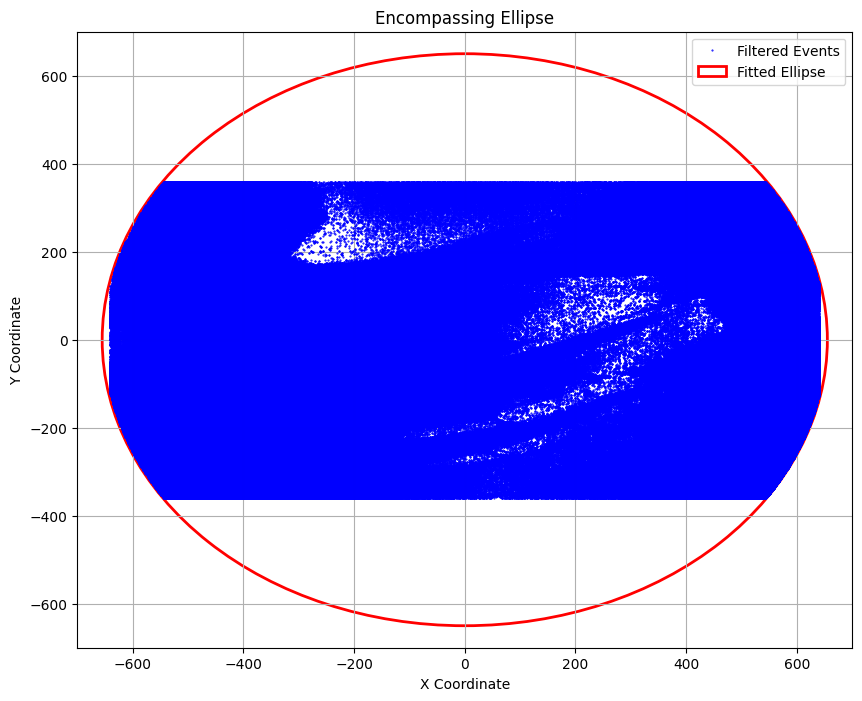

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.patches import Ellipse

x = events['x']
y = events['y']
points = np.column_stack((x, y))

distances = np.sqrt(x**2 + y**2)
percentile_cutoff = np.percentile(distances, 99)
filtered_points = points[distances <= percentile_cutoff]
x_filt, y_filt = filtered_points[:, 0], filtered_points[:, 1]

a_opt = 655
b_opt = 650
theta_opt = 0

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_filt, y_filt, 'b.', markersize=1, label='Filtered Events')

ellipse = Ellipse(
	xy=(0, 0),
	width=2*a_opt,
	height=2*b_opt,
	angle=np.degrees(theta_opt),
	edgecolor='red',
	facecolor='none',
	linewidth=2,
	label='Fitted Ellipse'
)
ax.add_patch(ellipse)

# Axis labels and limits
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Encompassing Ellipse')
plt.legend(loc='upper right')
plt.xlim(-700, 700)
plt.ylim(-700, 700)
plt.grid(True)
plt.show()

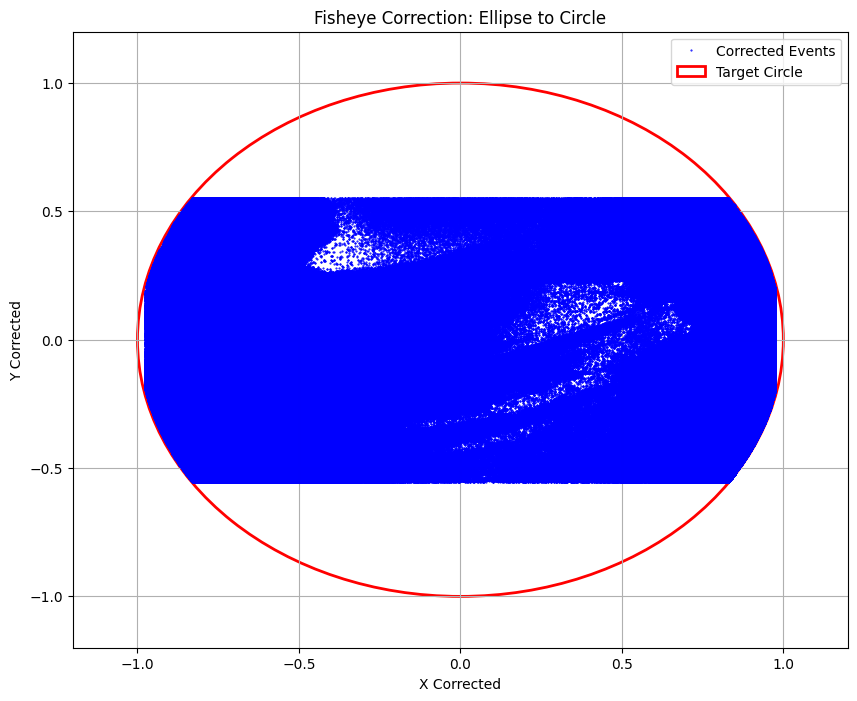

In [6]:
import numpy as np
import cv2

def correct_fisheye(x, y, a, b, theta=0):
	"""Maps ellipse coordinates to a circle."""
	cos_theta = np.cos(theta)
	sin_theta = np.sin(theta)
	x_rot = x * cos_theta + y * sin_theta
	y_rot = -x * sin_theta + y * cos_theta
	
	x_corrected = x_rot / a
	y_corrected = y_rot / b
	
	return x_corrected, y_corrected

x_corrected, y_corrected = correct_fisheye(x_filt, y_filt, a_opt, b_opt)

plt.figure(figsize=(10, 8))
plt.plot(x_corrected, y_corrected, 'b.', markersize=1, label='Corrected Events')

circle = plt.Circle((0, 0), 1, edgecolor='red', facecolor='none', linewidth=2, label='Target Circle')
plt.gca().add_patch(circle)

plt.xlabel('X Corrected')
plt.ylabel('Y Corrected')
plt.title('Fisheye Correction: Ellipse to Circle')
plt.legend(loc='upper right')
plt.grid(True)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.show()

Height: 720, Width: 1280
First event after transformation: (458, -262, 0, 1)
Data type of events['y']: int32


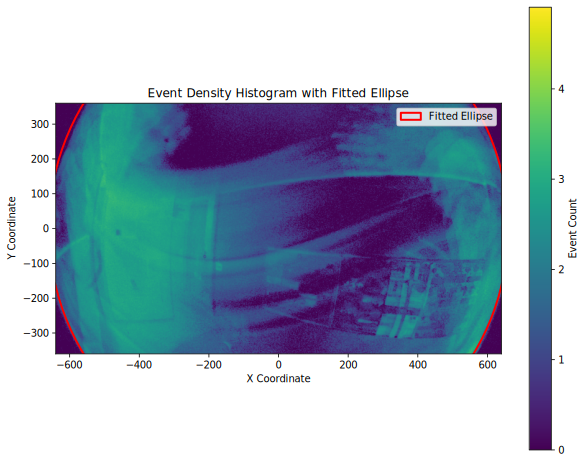

In [8]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize

from metavision_sdk_core import BaseFrameGenerationAlgorithm
from metavision_ml.preprocessing.viz import viz_histo
from metavision_ml.preprocessing.event_to_tensor import histo

calib_file = 'rssr_dataset/kalibrace_end/recording_2025-01-10_13-31-14.raw'
raw = RawReader(calib_file)

h, w = raw.get_size()
print(f"Height: {h}, Width: {w}")

start_ts = 0.5 * 1e6
dt = 7.5 * 1e6

raw.seek_time(start_ts)
delta_t = dt
events = raw.load_delta_t(delta_t)
events['t'] -= int(start_ts)

original_dtype = events.dtype
new_dtype = []
for field in original_dtype.names:
    if field in ['x', 'y']:
        new_dtype.append((field, np.int32))
    else:
        new_dtype.append((field, original_dtype[field]))
events = events.astype(new_dtype)

events_err = events[(events['x'] >= w) | (events['y'] >= h)]
if len(events_err) > 0:
    print(f"Warning: Found {len(events_err)} events outside frame!")
    print(events_err)

events['x'] -= w // 2
events['y'] -= h // 2

print(f"First event after transformation: {events[0]}")
print(f"Data type of events['y']: {events['y'].dtype}")

hist, x_edges, y_edges = np.histogram2d(
    events['x'],
    events['y'],
    bins=[w, h],
    range=[[-w//2, w//2], [-h//2, h//2]]
)


fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(np.log1p(hist.T), origin='lower', cmap='viridis',
               extent=[-w//2, w//2, -h//2, h//2])
plt.colorbar(im, label='Event Count')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Event Density Histogram with Fitted Ellipse')


a_opt = 660
b_opt = 680
theta_opt = 0

ellipse = Ellipse(
    xy=(0, 0),
    width=2 * a_opt,
    height=2 * b_opt,
    angle=np.degrees(theta_opt),
    edgecolor='red',
    facecolor='none',
    linewidth=2,
    label='Fitted Ellipse'
)
ax.add_patch(ellipse)
plt.legend(loc='upper right')
plt.show()
